# British Pub in Madrid?
## Final Project for Data Science Professional Certificate on Coursera.

### Table of Contents
* Introduction - The Business Problem
* Data
* Methodology
* Analysis
* Results and Discussion
* Conclusion

## Introduction - The Business Problem 

In the project, I will try and locate the best place for a company to set up a British/Irish-style pub in Madrid, Spain. There are already several of such pubs in Madrid, but I want to idenity which district would be the optimal.

Since there are lot of of these pubs in Madrid and since they are little bit of a novelty, it is prudent to work out their competition and in which areas they tend to be more popular or other types of bars or Tapas bars. It is also important to find a location as close to the central districts as possible.

#### Quick Note on Language

In this report, there are some Spanish words which are used which may be confusing for some readers:

* _Barrio_ - the Spanish equivalent of a neighbourhood
* _Distrito_ - the Spanish equivalent of a district
* _y_ - Spanish word for "and"

These words will be written in italics throughout this document e.g. _Barrio_

## Data

The nature of the problem requires the following information:
 
   * Number of pubs already in Madrid 
   * What their main competition is
   * Where they are located as opposed to the competition
   * Location compared to the city-centre

The following data will need to be extracted to perform this analysis:

* Location coordinates of Madrid districts/barrios (neighbourhoods)
* Number of British/Irish-style pubs already in Madrid
* Location of the competition
* Where such pubs are more popular than the competition

This data will be abstracted using **data scrapping** and the **Foursquare API**. The final analysis will including clustering the different venues to locate the most popular in each _Barrio_.

### _Distritos y Barrios_

To begin, let's show the location _Distritos_ and _Barrios_ inside of Madrid . To do these, I compiled a CSV file which contains all the coordinates of the _Barrios_ for Madrid, since trying to do it through scrapping proved an impossibility.

In [1]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_d5644340cad04494a91cc386c6105b1d = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Xbcm7bxAwDI_wPQknGUnPFSqyWomcjL4V2aXFkQX-As3',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_d5644340cad04494a91cc386c6105b1d.get_object(Bucket='madridvsbarcelonabritishpub-donotdelete-pr-8pmuhin4gpf3sd',Key='madrid_distritos_coord.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

madrid_distritos = pd.read_csv(body)
madrid_distritos.drop(columns = ['Unnamed: 0'])


,Distrito,Latitude,Longitude
0,Centro,40.415347,-3.707371
1,Arganzuela,40.402733,-3.695403
2,Retiro,40.402733,-3.695403
3,Salamanca,40.430000,-3.677778
4,Chamartín,40.453333,-3.6775
5,Tetuán,40.460556,-3.7
6,Chamberí,40.432792,-3.697186
7,Fuencarral-El Pardo,40.478611,-3.709722
8,Moncloa-Aravaca,40.435151,-3.718765
9,Latina,40.402461,-3.741294


In [2]:
body = client_d5644340cad04494a91cc386c6105b1d.get_object(Bucket='madridvsbarcelonabritishpub-donotdelete-pr-8pmuhin4gpf3sd',Key='madrid_barrios_lonlat.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

madrid_barrios = pd.read_csv(body)
madrid_barrios.head()

,ID,Barrio,Distrito,Latitude,Longitude
0,0,Palacio,Centro,40.415000,-3.713333
1,1,Embajadores,Centro,40.408889,-3.699722
2,2,Cortes,Centro,40.414167,-3.698056
3,3,Justicia,Centro,40.423889,-3.696389
4,4,Universidad,Centro,40.425278,-3.708333


Now let's map out the _Barrios_ and _Distritos_ out on a map:

In [173]:
#!pip install folium
import folium

# map of Madrid Distritos and Barrios
map_madrid_barrios = folium.Map(
    location=[40.416, -3.7038],
    zoom_start=12,
    tiles='Stamen Terrain'
)

# adding the blue dot markers to show Barrios
madrid_distritos.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], 
                                        popup=row['Distrito'],
                                        radius=35,
                                        color= "black",
                                        fill = True,
                                        fill_opacity = 0.0,
                                        ).add_to(map_madrid_barrios),
                                        axis=1)

# adding the black circles markers to show Distritos
madrid_barrios.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], 
                                        popup=row['Barrio'],
                                        radius=7,
                                        color='black',
                                        fill_color='blue',
                                        fill = True,
                                        fill_opacity = 0.7,
                                        ).add_to(map_madrid_barrios),
                                        axis=1)

map_madrid_barrios

This will help to build an accurate picture of which venues are more popular within each _Distrito_.

### Foursquare API

Now let's use the Foursquare API to get information on the venues in each of the _Distritos_ in Madrid.

In [6]:
CLIENT_ID = 'LRMKW1334NXRTWFIE2FWTZBNOFPK0C3CQTGWZVWY0VGKURXF' # Foursquare ID
CLIENT_SECRET = 'LL3VDC5I25YUPKTO53M1LWW5IET1DMGTDLOBRXXOUR43A5JK' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

Let's create a function to get the location information of all the venues in Madrid according to each _Barrios_

In [7]:
import requests

#fuction to get the nearby venues based on the location data
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Distrito', 
                  'Distrito Latitude', 
                  'Distrito Longitude', 
                  'Venue Name', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now let's use that function to create a pandas dataframe of this information

In [8]:
# dataframe of all Madrid Venues
madrid_venues = getNearbyVenues(names=madrid_barrios['Distrito'],
                                   latitudes=madrid_barrios['Latitude'],
                                   longitudes=madrid_barrios['Longitude']
                                  )
madrid_venues.head()

Centro
Centro
Centro
Centro
Centro
Centro
Arganzuela
Arganzuela
Arganzuela
Arganzuela
Arganzuela
Arganzuela
Arganzuela
Retiro
Retiro
Retiro
Retiro
Retiro
Retiro
Salamanca
Salamanca
Salamanca
Salamanca
Salamanca
Salamanca
Chamartín
Chamartín
Chamartín
Chamartín
Chamartín
Chamartín
Tetuán
Tetuán
Tetuán
Tetuán
Tetuán
Tetuán
Chamberí
Chamberí
Chamberí
Chamberí
Chamberí
Chamberí
Fuencarral-El Pardo
Fuencarral-El Pardo
Fuencarral-El Pardo
Fuencarral-El Pardo
Fuencarral-El Pardo
Fuencarral-El Pardo
Fuencarral-El Pardo
Fuencarral-El Pardo
Moncloa-Aravaca
Moncloa-Aravaca
Moncloa-Aravaca
Moncloa-Aravaca
Moncloa-Aravaca
Moncloa-Aravaca
Moncloa-Aravaca
Latina
Latina
Latina
Latina
Latina
Latina
Latina
Carabanchel
Carabanchel
Carabanchel
Carabanchel
Carabanchel
Carabanchel
Carabanchel
Usera
Usera
Usera
Usera
Usera
Usera
Usera
Puente de Vallecas
Puente de Vallecas
Puente de Vallecas
Puente de Vallecas
Puente de Vallecas
Puente de Vallecas
Moratalaz
Moratalaz
Moratalaz
Moratalaz
Moratalaz
Moratalaz
Ci

,Distrito,Distrito Latitude,Distrito Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Centro,40.415,-3.713333,Santa Iglesia Catedral de Santa María la Real ...,40.415767,-3.714516,Church
1,Centro,40.415,-3.713333,Plaza de La Almudena,40.416320,-3.713777,Plaza
2,Centro,40.415,-3.713333,Taberna Rayuela,40.413179,-3.713496,Tapas Restaurant
3,Centro,40.415,-3.713333,Cervecería La Mayor,40.415218,-3.712194,Beer Bar
4,Centro,40.415,-3.713333,Mercado Jamón Iberico,40.415442,-3.711643,Market


So now, let's have a look at all the types of venues in Madrid and then work out which ones are most appropriate for the analysis

In [9]:
# listing the venue categories in Madrid
madrid_venues['Venue Category'].unique()

array(['Church', 'Plaza', 'Tapas Restaurant', 'Beer Bar', 'Market',
       'Restaurant', 'Historic Site', 'Bar', 'Ice Cream Shop',
       'Performing Arts Venue', 'Garden', 'Palace', 'Peruvian Restaurant',
       'Café', 'Vegetarian / Vegan Restaurant', 'Spanish Restaurant',
       'Park', 'French Restaurant', 'Wine Bar', 'Opera House',
       'Gastropub', 'Gym / Fitness Center', 'Resort', 'Cocktail Bar',
       'Bistro', 'Pie Shop', 'Lounge', 'Other Nightlife',
       'Dumpling Restaurant', 'Hobby Shop', 'Pastry Shop',
       'Caucasian Restaurant', 'Flower Shop', 'Wine Shop',
       'Mexican Restaurant', 'American Restaurant', 'Music Venue',
       'Mediterranean Restaurant', 'Pub', 'Pizza Place', 'Road',
       'Ramen Restaurant', 'Hotel', 'Museum',
       'Modern European Restaurant', 'Beer Garden',
       'Argentinian Restaurant', 'Coffee Shop', 'Theater',
       'Seafood Restaurant', 'Sushi Restaurant', 'Bookstore',
       'Movie Theater', 'Art Gallery', 'Brewery', 'Circus', 'Eve

So from this list we can identify the main food categories which are related to the analysis. 

The list of those venues which should be included in our British/Irish-style pub list are:
* **Beer bar**
* **Gastropub**
* **Pub**
* **Irish Pub**
* **Beer garden**

And those venues which are selected for competition:

* **Tapas restaurant** - because these are very popular among the Spanish
* **Bar**
* **Wine Bar**

So let's now count the number of these British/Irish-style pubs in Madrid:

In [10]:
# list of all types of bar
madrid_all_bars = madrid_venues.loc[(madrid_venues['Venue Category'] == 'Pub') | 
                                (madrid_venues['Venue Category'] == 'Gastropub') | 
                                (madrid_venues['Venue Category'] == "Bar") |
                                (madrid_venues['Venue Category'] == "Irish Pub") |
                                (madrid_venues['Venue Category'] == "Wine Bar")|
                                (madrid_venues['Venue Category'] == "Beer Garden") |
                                (madrid_venues['Venue Category'] == "Tapas Restaurant")]

# list of all types of non-pub competition
madrid_bars = madrid_venues.loc[(madrid_venues['Venue Category'] == "Bar") |
                                (madrid_venues['Venue Category'] == "Wine Bar")|
                                (madrid_venues['Venue Category'] == "Tapas Restaurant")]

# list of all types of Pubs
madrid_pubs = madrid_venues.loc[(madrid_venues['Venue Category'] == 'Pub') | 
                                (madrid_venues['Venue Category'] == 'Gastropub') | 
                                (madrid_venues['Venue Category'] == "Irish Pub") |
                                (madrid_venues['Venue Category'] == "Beer Garden")]


print('Total number of Madrid Bars: ', madrid_all_bars['Venue Category'].count())
print('The number of Pubs in Madrid: ', madrid_pubs['Venue Category'].count())
print('Percentage of Pubs out of all venues in Madrid: ', (madrid_pubs['Venue Category'].count()/madrid_venues['Venue Category'].count() * 100))
print('Percentage of Pubs out all bars in Madrid ', (madrid_pubs['Venue Category'].count()/madrid_bars['Venue Category'].count() * 100))

Total number of Madrid Bars:  435
The number of Pubs in Madrid:  79
Percentage of Pubs out of all venues in Madrid:  2.1643835616438354
Percentage of Pubs out all bars in Madrid  22.191011235955056


Let's see all these pubs on a map

In [143]:
# map of Madrid Bar vs. Pubs
map_madrid_bars_vs_pubs = folium.Map(
    location=[40.416, -3.7038],
    zoom_start=12,
    tiles='Stamen Terrain'
)

# adding the red dot markers to show bars
madrid_bars.apply(lambda row:folium.CircleMarker(location=[row["Venue Latitude"], row["Venue Longitude"]], 
                                        popup=row['Venue Name'],
                                        radius=7,
                                        color='black',
                                        fill_color='red',
                                        fill = True,
                                        fill_opacity = 0.7,
                                        ).add_to(map_madrid_bars_vs_pubs),
                                        axis=1)

# adding the red dot markers to show pubs
madrid_pubs.apply(lambda row:folium.CircleMarker(location=[row["Venue Latitude"], row["Venue Longitude"]], 
                                        popup=row['Venue Name'],
                                        radius=7,
                                        color='black',
                                        fill_color='green',
                                        fill = True,
                                        fill_opacity = 0.7,
                                        ).add_to(map_madrid_bars_vs_pubs),
                                        axis=1)

map_madrid_bars_vs_pubs

* **Pubs = Green**
* **Other Bars = Red**

We can see on the map that the majority of these pubs are in around the centre of the city and more in the north of the city than in the south and they follow a similar distribution throughout the city as all the other bars.

## Methodology

In this project, I want to concentrate on finding the _Distrito_ in which a British/Irish-style pub would face the most competetion in Madrid.

In the first part of this study, I have gathered the relevant data on the locations of the both the _Distritos_ and _Barrios_ inside of the Madrid, and utilised the Foursquare API to gather information of all the venues within the city.

In the analysis part, I will break down the data on all the bars within Madrid and organise them according to each _Barrio_ which is the first, second and third most frequented in those areas. Based on this breakdown, I will then use K-Means clustering to view any patterns inside of the data which might emerge and analyse that data to see in which British/Irish-style pubs already located in Madrid are frequented more.

From this information, I will recommend where a British/Irish-style pub would be best located inside the Spanish capital.

## Analysis

Now we have had a look at the data, let's perform some analysis to work out the relationship between bars and pubs in Madrid. First, we will have a look at the most popular type of bar according to each _Distrito_ (rather than each _Barrio_ ) to get an idea of where they are most popular. Let's have a look which are the three most popular bars in each _Distrito_.

In [62]:
# one hot encoding
madrid_bars_onehot = pd.get_dummies(madrid_all_bars[['Venue Category']], prefix="", prefix_sep="")

# add Distrito column back to dataframe
madrid_bars_onehot['Distrito'] = madrid_all_bars['Distrito'] 

# move Distrito column to the first column
fixed_columns = [madrid_bars_onehot.columns[-1]] + list(madrid_bars_onehot.columns[:-1])
madrid_bars_onehot = madrid_bars_onehot[fixed_columns]

In [63]:
# grouping Madrid Bars dataframe by Distrito
madrid_bars_grouped = madrid_bars_onehot.groupby('Distrito').mean().reset_index()

num_top_venues = 3

In [64]:
import numpy as np

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Distrito']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
madrid_bars_sort = pd.DataFrame(columns=columns)
madrid_bars_sort['Distrito'] = madrid_bars_grouped['Distrito']

for ind in np.arange(madrid_bars_grouped.shape[0]):
    madrid_bars_sort.iloc[ind, 1:] = return_most_common_venues(madrid_bars_grouped.iloc[ind, :], num_top_venues)

madrid_bars_sort

,Distrito,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Arganzuela,Tapas Restaurant,Bar,Beer Garden
1,Barajas,Tapas Restaurant,Wine Bar,Gastropub
2,Carabanchel,Bar,Tapas Restaurant,Pub
3,Centro,Tapas Restaurant,Bar,Pub
4,Chamartín,Bar,Tapas Restaurant,Pub
5,Chamberí,Bar,Tapas Restaurant,Pub
6,Ciudad Lineal,Bar,Tapas Restaurant,Pub
7,Fuencarral-El Pardo,Tapas Restaurant,Wine Bar,Pub
8,Hortaleza,Pub,Irish Pub,Gastropub
9,Latina,Bar,Tapas Restaurant,Beer Garden


In [65]:
import matplotlib as plt
import matplotlib.colors as colors
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

madrid_bars_clustering = madrid_bars_grouped.drop('Distrito', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_bars_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 1, 0, 1, 1, 1, 2, 4, 1], dtype=int32)

In [66]:
# add clustering labels
madrid_bars_sort.insert(1, "Cluster Labels", kmeans.labels_)

madrid_bars_merged = madrid_bars

# merge madrid_bars_grouped with madrid_bars_sort to add latitude/longitude for each neighborhood
madrid_bars_merged = madrid_bars_merged.join(madrid_bars_sort.set_index('Distrito'), on='Distrito')

In [129]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

# create map of the Dar Clusters
bar_clusters = folium.Map(location=[40.416, -3.7038], 
                          zoom_start=12, 
                          tiles='Stamen Terrain')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_bars_merged['Venue Latitude'], madrid_bars_merged['Venue Longitude'], madrid_bars_merged['Distrito'], madrid_bars_merged["Cluster Labels"]):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(bar_clusters)
       
bar_clusters


So now we have used K-Means cluster analysis to see what clusters are present. From looking at the visual from the map, it is clear we have two large clusters and two smallers ones.

* **Cluster 0 = Red**
* **Cluster 1 = Purple**
* **Cluster 2 = Blue**
* **Cluster 3 = Green**

Let's now analyse these clusters in a little more detail through using a random sample of the dataframe above

In [115]:
#counts in each cluster
total_clusters = madrid_bars['Venue Category'].count()
cluster_0 = madrid_bars_merged.loc[(madrid_bars_merged["Cluster Labels"] == 0)].count()
cluster_1 = madrid_bars_merged.loc[(madrid_bars_merged["Cluster Labels"] == 1)].count()
cluster_2 = madrid_bars_merged.loc[(madrid_bars_merged["Cluster Labels"] == 2)].count()
cluster_3 = madrid_bars_merged.loc[(madrid_bars_merged["Cluster Labels"] == 3)].count()

#percentage in each cluster
cluster_0_per = cluster_0[["Cluster Labels"]] / total_clusters * 100
cluster_1_per = cluster_1[["Cluster Labels"]] / total_clusters * 100
cluster_2_per = cluster_2[["Cluster Labels"]] / total_clusters * 100
cluster_3_per = cluster_3[["Cluster Labels"]] / total_clusters * 100

#printing details of each cluster
print('Cluster Counts')
print("Cluster 0:", cluster_0[["Cluster Labels"]])
print("Cluster 1:", cluster_1[["Cluster Labels"]])
print("Cluster 2:", cluster_2[["Cluster Labels"]])
print("Cluster 3:", cluster_3[["Cluster Labels"]])
print("")
print('Cluster Percentages')
print("Cluster 0 %:", cluster_0_per)
print("Cluster 1 %:", cluster_1_per)
print("Cluster 2 %:", cluster_2_per)
print("Cluster 3 %:", cluster_3_per)



Cluster Counts
Cluster 0: Cluster Labels    133
dtype: int64
Cluster 1: Cluster Labels    213
dtype: int64
Cluster 2: Cluster Labels    6
dtype: int64
Cluster 3: Cluster Labels    4
dtype: int64

Cluster Percentages
Cluster 0 %: Cluster Labels    37.359551
dtype: float64
Cluster 1 %: Cluster Labels    59.831461
dtype: float64
Cluster 2 %: Cluster Labels    1.685393
dtype: float64
Cluster 3 %: Cluster Labels    1.123596
dtype: float64


Now we can see the percentages of these clusters within Madrid and it is clear that both Cluster 0 and Cluster 1 represent a very high percentage each. Let's generate a bar-graph to help visualise this:

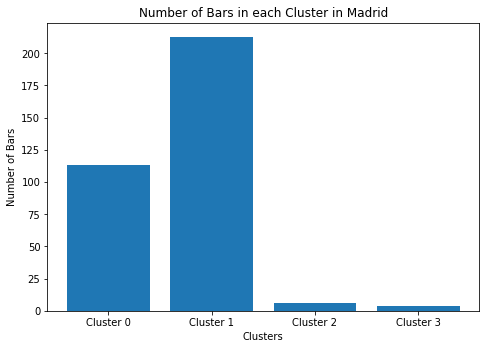

In [261]:
import matplotlib.pyplot as plt

#creating bar chart of cluster count
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
clusters = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
count = [113, 213, 6, 4]
ax.bar(clusters, count)
plt.xlabel('Clusters')
plt.ylabel('Number of Bars')
plt.title('Number of Bars in each Cluster in Madrid')

plt.show()

So now let's analyse what makes up these clusters through analysing the dataframe of the most popular venues

Cluster 0 is (Red) is charaterised by those barrios where the most common venues follow a pattern of Tapas Bar, Bar and then a Pub.

In [135]:
clsample_0 = madrid_bars_merged.loc[(madrid_bars_merged['Cluster Labels'] == 0)]

clsample_0.drop(columns = ['Distrito Latitude', 'Distrito Longitude', 'Venue Name', 'Venue Latitude', 'Venue Longitude', 'Venue Category']).sample(20)

,Distrito,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
461,Centro,0,Tapas Restaurant,Bar,Pub
222,Centro,0,Tapas Restaurant,Bar,Pub
3587,Barajas,0,Tapas Restaurant,Wine Bar,Gastropub
2060,Tetuán,0,Tapas Restaurant,Bar,Pub
1256,Salamanca,0,Tapas Restaurant,Bar,Wine Bar
1595,Salamanca,0,Tapas Restaurant,Bar,Wine Bar
2,Centro,0,Tapas Restaurant,Bar,Pub
86,Centro,0,Tapas Restaurant,Bar,Pub
1515,Salamanca,0,Tapas Restaurant,Bar,Wine Bar
2784,Moncloa-Aravaca,0,Tapas Restaurant,Bar,Gastropub


Cluster 1 (Purple) is charaterised by those barrios where the most common venues follow a pattern of Bar, Tapas Bar and then a Pub.

In [142]:
clsample_1 = madrid_bars_merged.loc[(madrid_bars_merged['Cluster Labels'] == 1)]

clsample_1.drop(columns = ['Distrito Latitude', 'Distrito Longitude', 'Venue Name', 'Venue Latitude', 'Venue Longitude', 'Venue Category']).sample(20)


,Distrito,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
3217,Ciudad Lineal,1,Bar,Tapas Restaurant,Pub
2474,Chamberí,1,Bar,Tapas Restaurant,Pub
2471,Chamberí,1,Bar,Tapas Restaurant,Pub
745,Arganzuela,1,Tapas Restaurant,Bar,Beer Garden
1753,Chamartín,1,Bar,Tapas Restaurant,Pub
2388,Chamberí,1,Bar,Tapas Restaurant,Pub
631,Arganzuela,1,Tapas Restaurant,Bar,Beer Garden
1864,Chamartín,1,Bar,Tapas Restaurant,Pub
2624,Chamberí,1,Bar,Tapas Restaurant,Pub
2402,Chamberí,1,Bar,Tapas Restaurant,Pub


Cluster 2 (Blue) is charaterised by those barrios where the most common venues follow a pattern of a Tapas Bar, but then followed by a Wine Bar and then by a Pub as the most popular.

In [125]:
clsample_2 = madrid_bars_merged.loc[(madrid_bars_merged['Cluster Labels'] == 2)]

clsample_2.drop(columns = ['Distrito Latitude', 'Distrito Longitude', 'Venue Name', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])


,Distrito,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
2717,Fuencarral-El Pardo,2,Tapas Restaurant,Wine Bar,Pub
2722,Fuencarral-El Pardo,2,Tapas Restaurant,Wine Bar,Pub
2745,Fuencarral-El Pardo,2,Tapas Restaurant,Wine Bar,Pub
3493,Vicálvaro,2,Tapas Restaurant,Wine Bar,Pub
3496,Vicálvaro,2,Tapas Restaurant,Wine Bar,Pub
3498,Vicálvaro,2,Tapas Restaurant,Wine Bar,Pub


Then in the last cluster, we have Tapas Bar as the third most frequented venue and a normal Bar as the most, with either a Wine Bar or Beer Garden as the second.

In [124]:
clsample_3 = madrid_bars_merged.loc[(madrid_bars_merged['Cluster Labels'] == 3)]

clsample_3.drop(columns = ['Distrito Latitude', 'Distrito Longitude', 'Venue Name', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])

,Distrito,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
3115,Moratalaz,3,Bar,Wine Bar,Tapas Restaurant
3117,Moratalaz,3,Bar,Wine Bar,Tapas Restaurant
3423,Villaverde,3,Bar,Beer Garden,Wine Bar
3447,Villaverde,3,Bar,Beer Garden,Wine Bar


Let's have another look at the map now with the _Distritos_ highlighted on them. It is clear that the majority of the clustering occurs within either cluster 0 or cluster 1 and there are very few places which fall into clusters outside of them. It is also worth noting that these smaller clusters are not in the city-centre, but located outside of the main metropolitan area. From obserseving the map, it is clear that the majority of the clustering falls within the _Distritos_ of:

* **Centro**
* **Arganzuela**
* **Chamberí**
* **Salamanca**
* **Moncloa-Aravaca**
* **Retiro**
* **Puente de Vallecas**

In [171]:
# create map the Distritos with clusters
bar_dist_clusters = folium.Map(location=[40.416, -3.7038], 
                          zoom_start=12, 
                          tiles='Stamen Terrain')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add cluster markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_bars_merged['Venue Latitude'], madrid_bars_merged['Venue Longitude'], madrid_bars_merged['Distrito'], madrid_bars_merged["Cluster Labels"]):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(bar_dist_clusters)

# adding the distritos markers to the map
madrid_distritos.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], 
                                        popup=row['Distrito'],
                                        radius=35,
                                        color= "black",
                                        fill = True,
                                        fill_opacity = 0.0,
                                        ).add_to(bar_dist_clusters),
                                        axis=1)

bar_dist_clusters


### Cluster Results

In none of the four clusters do British/Irish-style pubs overtake the other competition in Madrid, in the two major clusters which are closest to the centre of the city, the main competition in Cluster 0 is both a mix of Bar/Wine Bars and Tapas Restaurants, where, in some _Barrios_ , Pubs slip out of the picture. In Cluster 1, however, Pubs consisitently occupied the third position with most competition from either Tapas Bars or normal Bars.

Since the other two Clusters exist outside of the city-centre, I will not be including them in a recommendation on where to best put a British/Irish-style pubs in Madrid.

From the makeup of the Clusters and the type of competition from the paragraph above, let's concentrate on Cluster British/Irish-style pubs in a _Distrito_ from Cluster 1.

The following _Distritos_ are:

* **Chamberí**
* **Arganzuela**
* **Retiro**

### Number of Pubs

So now let's see how many pubs are in each of these _Distritos_

In [212]:
#count of pubs in each distrito
chamberi_pubs = madrid_pubs.loc[(madrid_pubs['Distrito'] == 'Chamberí')]
arganzuela_pubs = madrid_pubs.loc[(madrid_pubs['Distrito'] == 'Arganzuela')]
retiro_pubs = madrid_pubs.loc[(madrid_pubs['Distrito'] == 'Retiro')]

#printing counts
print("Number of Pubs in Chamberí:", chamberi_pubs['Distrito'].count())
print("Number of Pubs in Arganzuela:", arganzuela_pubs['Distrito'].count())
print("Number of Pubs in Retiro:", retiro_pubs['Distrito'].count())

Number of Pubs in Chamberí: 15
Number of Pubs in Arganzuela: 12
Number of Pubs in Retiro: 4


From what we see in these counts, the most number of Pubs are in Chamberí (15) and the least in Puente de Vallecas (1). 

So let's see how densely organised these pubs are in these four _Distritos_

### Observation from the Maps

So looking at the maps above of the different Distritos where Pubs are the Cluster 1, we can see that the pubs are fairly sparsely populated across each of the Distritos. 

In Chamberí, there is a cluster of pubs in the _Barrios_ of Gaztambide and Vallehermoso whereas the rest are more sparsely distributed. In Arganzuela, the pubs are more or less around the _Barrios_ of Legapzi, Acacias and Palos de Moguer. In Retiro, there are only four pubs, three of which are in the Barrio of Ibiza and the remaining on in Jerónimos.

In [258]:
map_chamberi_pubs = folium.Map(
    location=[40.432792, -3.697186],
    zoom_start=15,
    align = 'Centre',
    tiles='Stamen Terrain'
)

# markers for pubs in Chamberí in red
chamberi_pubs.apply(lambda row:folium.CircleMarker(location=[row["Venue Latitude"], row["Venue Longitude"]], 
                                        popup=row['Venue Name'],
                                        radius=7,
                                        color='red',
                                        fill_color='red',
                                        fill = True,
                                        fill_opacity = 0.7,
                                        ).add_to(map_chamberi_pubs),
                                        axis=1)

# adding only the relevant Barrio circles 
barrios_chamberi = madrid_barrios.loc[(madrid_barrios['Distrito'] == 'Chamberí')]

# adding the Barrio circle markers
barrios_chamberi.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], 
                                        popup=row['Barrio'],
                                        radius=80,
                                        color='blue',
                                        fill_color='blue',
                                        fill = True,
                                        ).add_to(map_chamberi_pubs),
                                        axis=1)

map_chamberi_pubs

In [260]:
map_arganzuela_pubs = folium.Map(
    location=[40.402733, -3.695403],
    zoom_start=15,
    tiles='Stamen Terrain'
)

# markers for pubs in Arganzuela in red
arganzuela_pubs.apply(lambda row:folium.CircleMarker(location=[row["Venue Latitude"], row["Venue Longitude"]], 
                                        popup=row['Venue Name'],
                                        radius=7,
                                        color='green',
                                        fill_color='green',
                                        fill = True,
                                        fill_opacity = 0.7,
                                        ).add_to(map_arganzuela_pubs),
                                        axis=1)

# adding only the relevant Barrio circles 
barrios_arganzuela = madrid_barrios.loc[(madrid_barrios['Distrito'] == 'Arganzuela')]

# adding the Barrio circle markers
barrios_arganzuela.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], 
                                        popup=row['Barrio'],
                                        radius=80,
                                        color='blue',
                                        fill_color='blue',
                                        fill = True,
                                        ).add_to(map_arganzuela_pubs),
                                        axis=1)


map_arganzuela_pubs

In [255]:
map_retiro_pubs = folium.Map(
    location=[40.402733, -3.695403],
    zoom_start=14.45,
    tiles='Stamen Terrain'
)

# markers for pubs in Retiro in red
retiro_pubs.apply(lambda row:folium.CircleMarker(location=[row["Venue Latitude"], row["Venue Longitude"]], 
                                        popup=row['Venue Name'],
                                        radius=7,
                                        color='yellow',
                                        fill_color='yellow',
                                        fill = True,
                                        fill_opacity = 0.7,
                                        ).add_to(map_retiro_pubs),
                                        axis=1)

# adding the Barrio circle markers
barrios_retiro = madrid_barrios.loc[(madrid_barrios['Distrito'] == 'Retiro')]

barrios_retiro.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], 
                                        popup=row['Barrio'],
                                        radius=80,
                                        color='blue',
                                        fill_color='blue',
                                        fill = True,
                                        ).add_to(map_retiro_pubs),
                                        axis=1)

map_retiro_pubs

## Results and Discussion

The analysis shows that there are a number of places in which a British/Irish-style pub could thrive, however it also shows that there are some speicific locations where one would benefit from the lowest amount of competition from both non-pub rivals, such as Tapas Bars, Bars and Wine Bars, and also competition from other Pubs.

The important part of this investigation was to find the popularity of the existing British/Irish-style pubs in Madrid as opposed to its main competition. The Cluster analysis revealed that, although there was no where a pub outstripped its rivals in frequentedness, there are still better locations than others where that competition is slightly less.

Observing the number of pubs in these Clusters, breaking down their location down to where they are located in each Barrio, the ideal location can be determined. First, after having found the location in which a Pub does best against its non-pub competition and still remains close the city-centre, the the next step was to find out the concentration of those pubs within those _Distritos_ to find the optimal location where other Pub competition is minimal, but where there is still demand.

From examining the break down of each of more popular _Distritos_ for pub within the chosen ideal Cluster it shows that either in eastern parts of Chamberí, in the Barrio of Ríos Rosas for example, and the Barrio of Niño Jesús in Retiro would be where a British/Irish-style pub would benefit from both low competition and closeness to the city-centre.

## Conclusion

The intent and purpose of this project was to determine the ideal location for putting a British/Irish-style pub in the Spanish capital of Madrid. By calculating the distribution of already existing pub alongside their competition, we now have a rough idea of where such a venue would do well. Although further analysis is recommended, such as looking into the individual success of each pub and the demographic makeup surrounding more popular one, we can safely assume that this analysis provides some suggestion as to where to start.

The ultimate decision of a pub's location will of course be made by the owners of it, and perhaps they may consider other factors which will require more investigation and analysis, yet this project can be a good base to continue from.